# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import matplotlib
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib
from dateutil.parser import parse
from time import time
from datetime import datetime
import time
import string
import timeit
import threading
from tqdm import tqdm
import sys
import re
import os
import random
from sklearn.metrics import roc_curve
from pandas.plotting import scatter_matrix
from IPython.display import display
import matplotlib.ticker as mtick
import matplotlib.pylab as pylab
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn import metrics
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import svm, tree, linear_model, neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline


color = sns.color_palette()
pd.options.display.max_columns = None


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# warnings.filterwarnings('ignore')


In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv",
                    na_values=["NA", "#VALUE!"], index_col='INDEX')
print(churn.shape)
churn.head()


(46206, 21)


,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
schema = pd.read_csv('files/MobileChurnDataDictionary.csv')

In [4]:
# Display specific feature's description for easy understanding

Var_name = 'CFU'
print(schema[schema['Variable_name'] == Var_name].Description)
churn[Var_name].unique()


4    Customer facing unit derived based on owning cost centre
Name: Description, dtype: object


array(['CONSUMER', 'SMALL BUSINESS'], dtype=object)

## Exploratory analysis

In [5]:
churn_rate = churn["CHURN_IND"].value_counts()/46206*100
churn_rate = churn_rate.rename({0:'Loyal',1:'Churned'})
churn_rate

Loyal      61.498507
Churned    38.501493
Name: CHURN_IND, dtype: float64

Text(0, 0.5, '%')

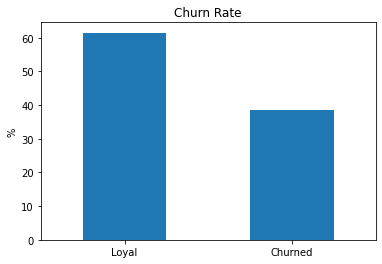

In [6]:
# check churn rate
churn_rate.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Churn Rate")
plt.ylabel("%")


Is this normal for Optus? If the sampling method is random and true to their business, then they definitely need to be more careful with their churn rate.

In [7]:
# plot the numerical_features

numerical_features = ['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'SERVICE_TENURE', 'PLAN_ACCESS_FEE', 'PLAN_TENURE',
                      'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND']


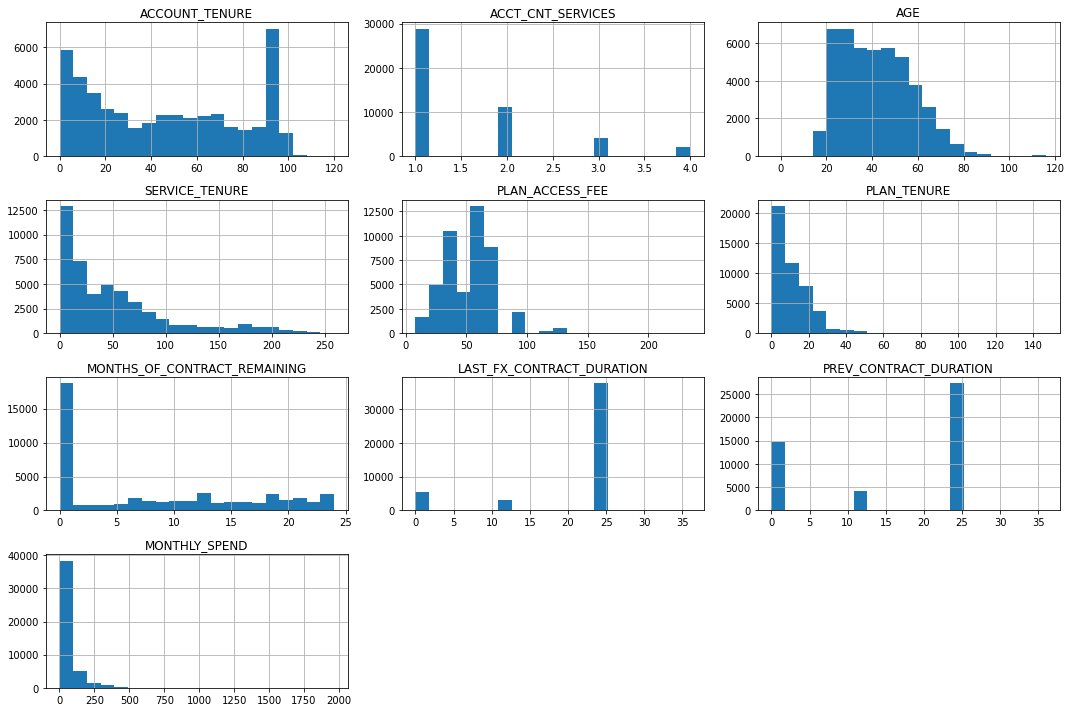

In [8]:
churn[numerical_features].hist(bins=20, figsize=(15, 10), layout=(4, 3))
plt.tight_layout()


Looks like the dataset consists of mostly new (service tenure and plan tenure). For some reason, most of the customers' contracts are about to expire (months of contract remaining). Also the monthly spend look wrong, some of the customers must be spending a lot on their mobile plans.

In [9]:
# Check monthly spend

churn.sort_values(by='MONTHLY_SPEND', ascending=False).head(20)


,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
46073,79291,2,1,22.0,CONSUMER,2,45.45,BYO,1,0,0,NO-CONTRACT,0,APPLE,0,1965.89,METRO,NSW,0.0,0.0,0.0
42752,73898,1,1,41.0,CONSUMER,1,36.36,NON BYO,1,23,24,ON-CONTRACT,0,SAMSUNG,0,1613.61,COUNTRY,NSW,0.0,0.0,0.0
3362,7449,3,2,21.0,SMALL BUSINESS,3,122.72,NON BYO,3,21,24,ON-CONTRACT,0,SAMSUNG,1,1286.57,COUNTRY,QLD,NaN,NaN,NaN
10690,23201,3,1,32.0,CONSUMER,3,54.54,BYO,0,0,0,NO-CONTRACT,0,SAMSUNG,1,1271.93,METRO,NSW,NaN,NaN,NaN
7407,16625,74,1,28.0,CONSUMER,74,122.72,NON BYO,1,21,24,ON-CONTRACT,24,SAMSUNG,1,1166.90,COUNTRY,QLD,NaN,NaN,NaN
8349,18664,2,1,21.0,CONSUMER,2,54.54,NON BYO,2,22,24,ON-CONTRACT,0,APPLE,1,1123.05,METRO,VIC,NaN,NaN,NaN
37568,65630,1,1,26.0,CONSUMER,1,122.72,NON BYO,1,23,24,ON-CONTRACT,0,APPLE,0,1101.44,COUNTRY,WA,0.0,0.0,0.0
13686,28411,71,3,NaN,SMALL BUSINESS,9,72.72,NON BYO,3,21,24,ON-CONTRACT,24,APPLE,0,1084.53,METRO,VIC,0.0,0.0,0.0
7947,17800,93,2,63.0,SMALL BUSINESS,214,72.72,NON BYO,14,10,24,ON-CONTRACT,12,APPLE,1,1062.63,METRO,WA,NaN,NaN,NaN


Looks like the small business customers are spending a lot, but there are also a lot of consumers spending just as much. Maybe they are sole traders, or there are mistakes in categorizing the CFU.

But since there's no way of telling why some of the consumers are spending that much, I think I'll let it go and just build a modle with this data.

In [10]:
categorica_features = ['CFU', 'BYO_PLAN_STATUS', 'CONTRACT_STATUS',
                       'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE']


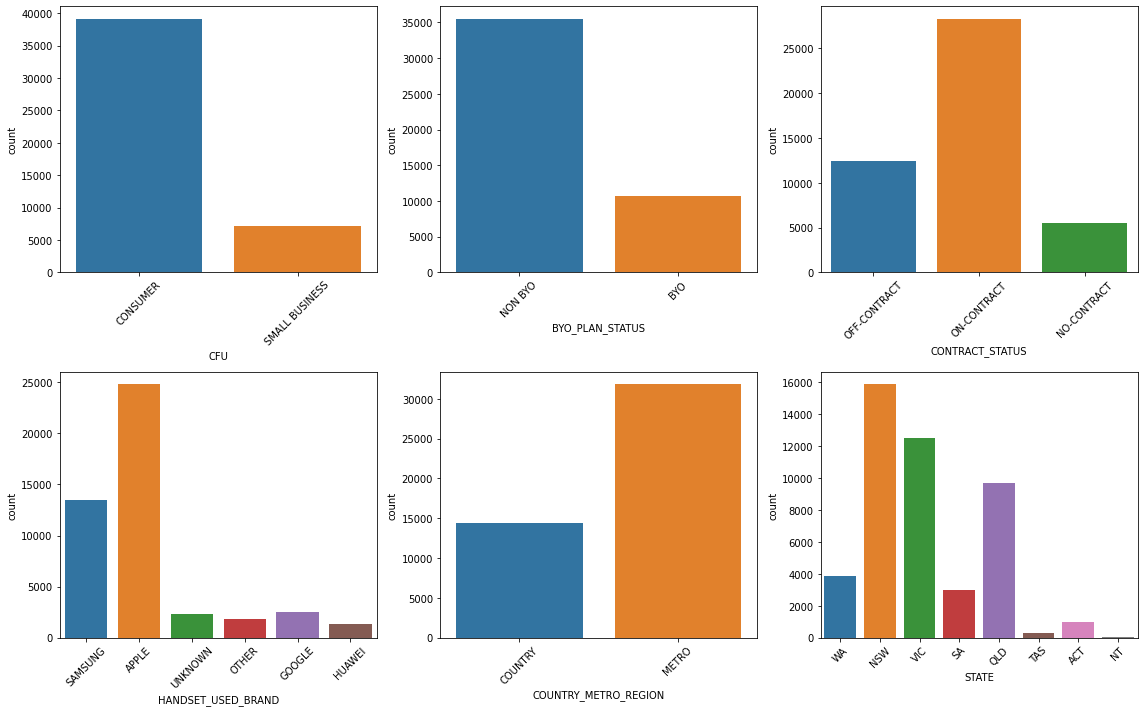

In [11]:
# Categorical Data

fig, ax = plt.subplots(2, 3, figsize=(16, 10))

for feature, subplot in zip(categorica_features, ax.flatten()):
    sns.countplot(x=churn[feature], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()


## Data Preprocessing

In [12]:
df = churn.drop(['CUST_ID','RECON_SMS_NEXT_MTH','RECON_TELE_NEXT_MTH','RECON_EMAIL_NEXT_MTH'], axis=1)
df.isnull().sum()[df.isnull().sum()!=0]


AGE                     76
COUNTRY_METRO_REGION     1
STATE                    1
dtype: int64

In [13]:
print(df.shape)
df.head()


(46206, 17)


,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


In [14]:
# Comparing the number of entries with null values (77) to the total number of samples (46206),
# the missing values won't make much a difference in the model.
# Dropping these rows now.
df = df.dropna()
print('dropped rows:', churn.shape[0] - df.shape[0])

dropped rows: 77


In [15]:
# Convert text features
# Get dummies but somewhat avoid dummy variable trap for these features
df = pd.get_dummies(df, columns=['CFU','BYO_PLAN_STATUS','CONTRACT_STATUS','COUNTRY_METRO_REGION'], drop_first=True) 

# Leaving these in because they don't matter much, but I'd like them to be shown
df = pd.get_dummies(df, columns=['HANDSET_USED_BRAND','STATE'])

## Find positive and negative correlations

In [16]:
# use corr() to get a general idea of which features are more likely to be important than others.

correlations = (df.corr().CHURN_IND).sort_values(ascending=False)
correlations = correlations[1:]


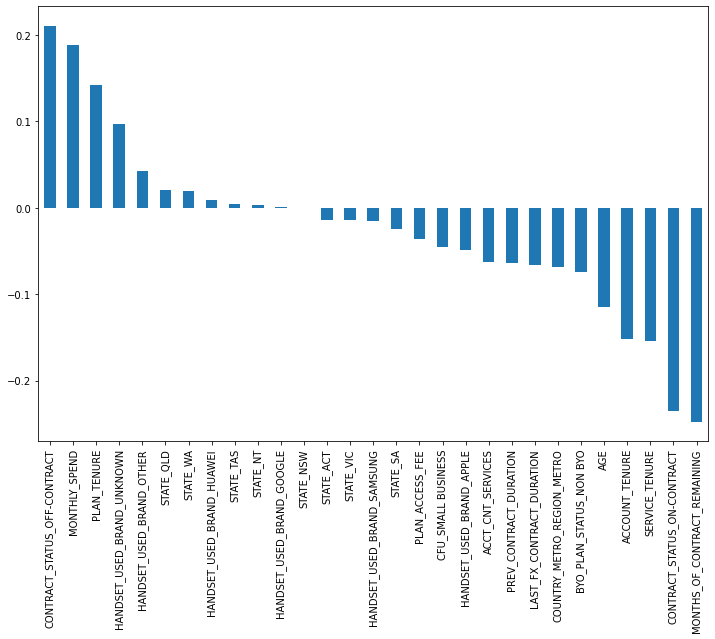

In [17]:
plt.figure(figsize=(12,8))
correlations.plot.bar()
None

## Model training

In [18]:
X = df.drop(['CHURN_IND'], axis=1)
y = df['CHURN_IND']

In [19]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("Shape of X_train dataset: ", X_train.shape)
print("Shape of y_train dataset: ", y_train.shape)
print("Shape of X_test dataset: ", X_test.shape)
print("Shape of y_test dataset: ", y_test.shape)

Shape of X_train dataset:  (36903, 29)
Shape of y_train dataset:  (36903,)
Shape of X_test dataset:  (9226, 29)
Shape of y_test dataset:  (9226,)


In [20]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

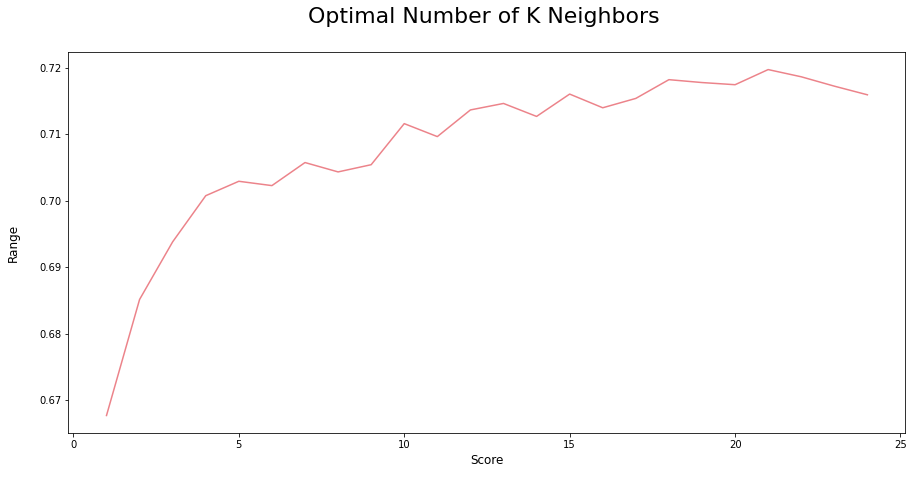

In [21]:
neighbours = []
for each in range(1, 25):
    knn_loop = KNeighborsClassifier(n_neighbors=each)
# set K neighbor as 3
    knn_loop.fit(X_train, y_train)
    neighbours.append(knn_loop.score(X_test, y_test))
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1, 25), neighbours, color='#ec838a')
plt.ylabel('Range\n', horizontalalignment="center",
           fontstyle="normal", fontsize="large",
           fontfamily="sans-serif")
plt.xlabel('Score\n', horizontalalignment="center",
           fontstyle="normal", fontsize="large",
           fontfamily="sans-serif")
plt.title('Optimal Number of K Neighbors \n',
          horizontalalignment="center", fontstyle="normal",
          fontsize="22", fontfamily="sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()


In [22]:
neighbours = neighbours.index(max(neighbours))

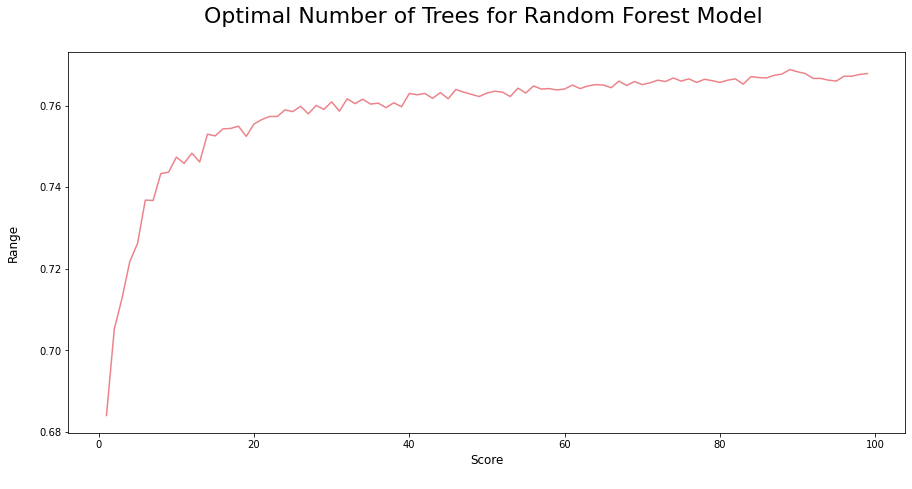

In [23]:
trees = []
for each in range(1,100):
    rf_loop = RandomForestClassifier(
n_estimators = each, random_state = 1) 
    rf_loop.fit(X_train,y_train)
    trees.append(rf_loop.score(X_test,y_test))
 
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,100),trees, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [24]:
trees = trees.index(max(trees))

In [25]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0, class_weight='balanced')))
models.append(('SVC', SVC(kernel = 'linear', random_state = 0)))
models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = neighbours, metric = 'minkowski', p = 2)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=trees, criterion = 'entropy', random_state = 0)))
# Evaluating Model Results:
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD','Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0
# Evaluate each model using k-fold cross-validation:
n_splits = 2
for name, model in models:
    kfold = model_selection.KFold(n_splits=n_splits)
# accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
# roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name, round(cv_auc_results.mean()*100, 2), round(cv_auc_results.std()*100, 2), round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
    
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)


## Random Forest Model Evaluation

In [26]:
classifier = RandomForestClassifier(n_estimators=trees, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [27]:
acc = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)"  % (acc.mean(), acc.std() * 2))

Random Forest Classifier Accuracy: 0.76 (+/- 0.01)


<Figure size 720x576 with 0 Axes>

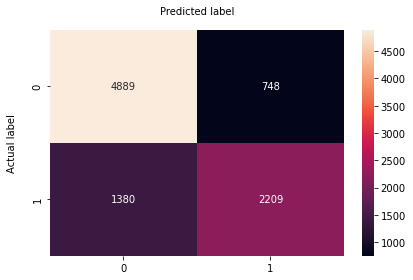

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='g')
class_names=[0, 1]
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
plt.tight_layout()
None


We have got an accuracy of 76%; signalling the characteristics of a reasonably good model.

## Final Results / Future Prediction

In [29]:
predicted = classifier.predict(X)
final = df
final['Predicted']=predicted


In [34]:
final[["CHURN_IND","Predicted"]].sample(20)

,CHURN_IND,Predicted
INDEX,,
20425,0,0
16446,0,0
39495,1,0
4902,1,1
27547,0,0
26869,0,0
20570,0,1
35629,0,0
42849,0,0
